In [1]:
import keras
from keras.layers import Conv2D, PReLU, MaxPooling2D, Dense, Permute, Flatten, Input
from keras.models import Model

Using TensorFlow backend.


In [2]:
img_path = "test1.jpg"

**创建Pnet**

In [3]:
def pnet(weight_path=None):
    input_tensor = Input([None, None, 3])
    x = Conv2D(filters=10, kernel_size=(3,3), strides=1, name = 'conv1' )(input_tensor)
    x = PReLU(shared_axes=[1,2], name = 'PReLU1')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(filters=16, kernel_size=(3,3), strides=1, name = 'conv2')(x)
    x = PReLU(shared_axes=[1,2], name='PReLU2')(x)

    x = Conv2D(filters=32, kernel_size = (3,3), strides = 1, name='conv3')(x)
    x = PReLU(shared_axes = [1,2], name='PReLU3')(x)

    classifier = Conv2D(filters=2, kernel_size=(1,1), activation = 'softmax', name='conv4-1')(x)
    bbox = Conv2D(filters=4, kernel_size = (1,1), name='conv4-2')(x)
    
    model = Model([input_tensor], [classifier, bbox])
    if weight_path :
        model.load_weights(weight_path, by_name = True)
    return model

**创建Rnet**

In [4]:
def rnet(weight_path):
    input_tensor = Input([24, 24, 3])
    x = Conv2D(filters=28, kernel_size=(3,3), strides=1, padding = 'valid', name = 'conv1')(input_tensor)
    x = PReLU(shared_axes=[1,2], name = 'prelu1')(x)
    x = MaxPooling2D(pool_size=(3,3), strides = 2, padding = 'same')(x)

    x = Conv2D(filters=48, kernel_size = (3,3), strides = 1, name = 'conv2')(x)
    x = PReLU(shared_axes=[1,2], name = 'prelu2')(x)
    x = MaxPooling2D(pool_size = (3,3), strides = 2)(x)

    x = Conv2D(filters = 64, kernel_size = (2,2), strides = 1, name = 'conv3')(x)
    x = PReLU(shared_axes=[1,2], name = 'prelu3')(x)

    x = Permute((3,2,1))(x)

    x = Flatten()(x)

    x = Dense(128, name = 'conv4')(x)
    x = PReLU(name='prelu4')(x)

    classifier = Dense(2, activation='softmax',name='conv5-1')(x)
    bbox = Dense(4,name='conv5-2')(x)

    model = Model([input_tensor], [classifier, bbox])
    model.load_weights(weight_path, by_name=True)
    return model

**创建Onet**

In [5]:
def onet(weight_path):
    input_tensor = Input([48,48,3])
    x = Conv2D(filters=32, kernel_size=(3,3), strides=1,name='conv1')(input_tensor)
    x = PReLU(shared_axes=[1,2],name='prelu1')(x)
    x = MaxPooling2D(pool_size=(3,3), strides = 2)(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1,name = 'conv2')(x)
    x = PReLU(shared_axes=[1,2],name = 'prelu2')(x)
    x = MaxPooling2D(pool_size=(3,3), strides = 2, padding = 'same')(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1,name='conv3')(x)
    x = PReLU(shared_axes=[1,2],name='prelu3')(x)
    x = MaxPooling2D(pool_size=(2,2), strides = 2)(x)

    x = Conv2D(filters=128, kernel_size=(2,2), strides=1,name='conv4')(x)
    x = PReLU(shared_axes=[1,2],name='prelu4')(x)

    x = Permute((3,2,1))(x)
    x = Flatten()(x)
    x = Dense(256,name='conv5')(x)
    x = PReLU(name='prelu5')(x)

    classifier = Dense(2, activation = 'softmax',name='conv6-1')(x)
    bbox = Dense(4,name='conv6-2')(x)
    faceland = Dense(10,name='conv6-3')(x)

    model = Model([input_tensor],[classifier, bbox, faceland])
    model.load_weights(weight_path, by_name=True)
    return model

In [6]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(img_path)

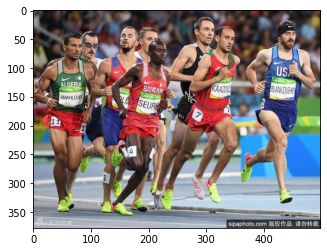

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [8]:
copy_img = (img.copy() - 127.5)/127.5

In [9]:
copy_img.shape

(378, 499, 3)

In [10]:
original_h, orginal_w, _ = copy_img.shape

In [11]:
def calculateScales(img):
    copy_img = img.copy()
    h,w,_ = copy_img.shape
    # 引申优化项
    pr_scale = 1.0
    
    if min(h,w) > 500:
        pr_scale = 500 / min(h, w)
        h = int(pr_scale * h)
        w = int(pr_scale * w)
    
    elif max(h, w) < 500:
        pr_scale = 500 / max(h, w)
        h = int(pr_scale * h)
        w = int(pr_scale * w)
    
    factor = 0.709
    lmin = min(h, w)
    factor_count = 0
    scales = []
    while lmin >= 12:
        scale = pr_scale * pow(factor, factor_count)
        lmin *= factor
        factor_count += 1
        scales.append(scale)
    return scales

In [12]:
scales = calculateScales(img)
len(scales)

11

In [13]:
out = []
for scale in scales:
    hs = int(scale * original_h)
    ws = int(scale * orginal_w)
    scaled_img = cv2.resize(copy_img, (ws, hs))
    inputs_img = scaled_img.reshape(1, *scaled_img.shape)
    print(inputs_img.shape)
    p_model = pnet("pnet.h5")
#     p_model = pnet()
    output = p_model.predict(inputs_img)
    out.append(output)

(1, 378, 499, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.



2026-01-08 19:33:34.930599: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2026-01-08 19:33:34.961994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: NVIDIA GeForce RTX 2080 Ti major: 7 minor: 5 memoryClockRate(GHz): 1.545
pciBusID: 0000:23:00.0
2026-01-08 19:33:34.962438: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2026-01-08 19:33:34.964650: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2026-01-08 19:33:34.966518: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2026-01-08 19:33:34.967223: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2026-01-08 19:33:34.969786: I tensorflow/stream_executor

2026-01-08 19:33:36.113972: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2026-01-08 19:33:37.725255: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


(1, 268, 354, 3)
(1, 190, 251, 3)
(1, 134, 178, 3)
(1, 95, 126, 3)
(1, 67, 89, 3)
(1, 48, 63, 3)
(1, 34, 45, 3)
(1, 24, 31, 3)
(1, 17, 22, 3)
(1, 12, 16, 3)


In [14]:
image_num = len(out)
image_num

11

In [15]:
out[-1][0][0].shape

(1, 3, 2)

In [16]:
out[-1][0][0][:,:,1].shape

(1, 3)

In [17]:
def rec2Squre(rectangle):
    """
        rectangle: [1,5] x1,y1,x2,y2,score
    """
    w = rectangle[:, 2] - rectangle[:, 0]
    h = rectangle[:, 3] - rectangle[:, 1]
    l = np.maximum(w,h).T
    rectangle[:, 0] = rectangle[:, 0] + w * 0.5 - l * 0.5
    rectangle[:, 1] = rectangle[:, 1] + h * 0.5 - l * 0.5
    rectangle[:, 2:4] = rectangle[:, 0:2] + np.repeat([l], 2, axis = 0).T
    return rectangle

**NMS非极大值抑制实现**

In [18]:
def NMS(rectangles, threshold):
    """
        Args:
        rectangels: shape[n, 5]
        
    """
    if len(rectangles) == 0:
        return rectangles
    boxes = np.array(rectangles)
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    sc = boxes[:,4]
    
    area = np.multiply(x2-x1+1, y2-y1+1)
    I = np.array(sc.argsort())
    pick = []
    while(len(I) > 0):
        xx1 = np.maximum(x1[I[-1]], x1[I[0:-1]])
        yy1 = np.maximum(y1[I[-1]], y1[I[0:-1]])
        xx2 = np.minimum(x2[I[-1]], x2[I[0:-1]])
        yy2 = np.minimum(y2[I[-1]], y2[I[0:-1]])
        
        w = np.maximum(0, xx2-xx1+1)
        h = np.maximum(0, yy2-yy1+1)
        
        inter = w * h
        
        iou = inter / (area[I[-1]] + area[I[0:-1]] - inter)
        pick.append(I[-1])
        I = I[np.where(iou <= threshold)[0]]
    res = boxes[pick].tolist()
    return res
    

In [19]:
import numpy as np
def pnet_process(cls_prob, roi, out_side, scale, width, height, threshold):
    cls_prob = np.swapaxes(cls_prob, 0, 1)
    roi = np.swapaxes(roi, 0,2)
    
    (x,y) = np.where(cls_prob >= threshold)
    stride = 0
    if out_side!= 1:
        stride = (2 * out_side - 1) / (out_side - 1)
    boundingbox = np.array([x,y]).T
    
    bb1 = np.fix((stride*(boundingbox) + 0) * scale)
    bb2 = np.fix((stride*(boundingbox) + 11) * scale)
    
    boundingbox = np.concatenate((bb1,bb2), axis = 1)
    
    dx1 = roi[0][x,y]
    dx2 = roi[1][x,y]
    dx3 = roi[2][x,y]
    dx4 = roi[3][x,y]
    
    score = np.array([cls_prob[x,y]]).T
    offset = np.array([dx1,dx2,dx3,dx4]).T
    
    boundingbox = boundingbox + offset * 12 * scale
    
    rectangles = np.concatenate((boundingbox, score),axis = 1)
#     print(rectangles)
    rectangles = rec2Squre(rectangles)
    pick = []
    for i in range(len(rectangles)):
        x1 = int(max(rectangles[i][0],0))
        y1 = int(max(rectangles[i][1],0))
        x2 = int(min(rectangles[i][2],width))
        y2 = int(min(rectangles[i][3],height))
        sc = rectangles[i][4]
        if x2>x1 and y2>y1:
            pick.append(rectangles[i])
#     print(f"pick length is {len(pick)}")
    return NMS(pick, 0.3)
#     return rectangles
    
        
    
    
    

In [20]:
rec = []
for i in range(image_num):
    cls_prob = out[i][0][0][:,:,1]  # (h,w)
#     print( cls_prob.shape)
    roi = out[i][1][0]   #(h, w, 4)
#     print(roi.shape)
    h, w = cls_prob.shape
    out_side = max(h, w)
    rectangles = pnet_process(cls_prob, roi, out_side, 1/scales[i], 512,512, 0.5)
#     print(rectangles)
    rec.extend(rectangles)

rec = NMS(rec, 0.7)
print(len(rec))
# print(rec)



666


In [21]:
rec[0][0:2]

[427.10710448026657, 30.932257413864136]

**no weight path**
57116
535
317
3064
2676
1414
59
191
100
15
8

**展示pnet的输出结果**

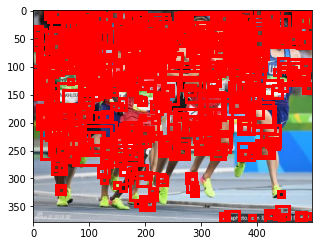

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

img = Image.open(img_path)
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(img)

for i in range(len(rec)):
    draw_rec = patches.Rectangle(rec[i][0:2], rec[i][2]-rec[i][0], rec[i][3]-rec[i][1], facecolor = 'None', edgecolor = 'r', linewidth = 3)
    ax.add_patch(draw_rec)


**Rnet处理**

获取PNET输出的结果rec, `shape:[n, 5]`, `x1, y1, x2, y2, sc`

In [23]:
len(rec)

666

In [24]:
print(int(rec[0][3]))
print(int(rec[0][1]))

62
30


In [25]:

predict_rnet_batch = []
for rectangle in rec:
    crop_img = copy_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
    h,w,_ = crop_img.shape
    if h == 0 or w == 0:
        continue
    scaled_img = cv2.resize(crop_img, (24,24))
    predict_rnet_batch.append(scaled_img)

In [26]:
len(predict_rnet_batch)

646

In [27]:
predict_rnet_batch = np.array(predict_rnet_batch)
r_model = rnet("rnet.h5")
rnet_out = r_model.predict(predict_rnet_batch)

Rnet输出结果：len = 2
* out[0]: classifier [n,2]
* out[1]: roi        [n,4]

In [28]:
len(rnet_out)

2

In [29]:
rnet_out[1][0]

array([ 0.08845437, -0.01072894, -0.06824004,  0.04627389], dtype=float32)

In [30]:
cls_prob = np.array(rnet_out[0])
roi = np.array(rnet_out[1])


**对Rnet输出的结果进行后处理**
Args：
* cls_prob: 有人脸的类别概率 [n,2]
* roi: 人脸坐标[n,4] 偏移量
* rectangles: pnet输出的结果 [n,5] x1,y1,x2,y2,sc
* original_h: 原图的h
* original_w: 原图的w
* threshold：概率阈值

处理流程：
* 根据阈值找到符合条件的点
* 找到rectangle里面的x1,y1,x2,y2,sc
* 找到roi输出的偏移量，并与rectangle结合
* 输出rectangle


In [31]:
def rnet_process(cls_prob, roi, rectangles, original_h, original_w, threshold):
    prob = cls_prob[:, 1]
    pick = np.where(prob >= threshold)
    print(pick)
    rectangles = np.array(rectangles)
    
    x1 = rectangles[pick, 0]
    y1 = rectangles[pick, 1]
    x2 = rectangles[pick, 2]
    y2 = rectangles[pick, 3]

    sc = np.array([prob[pick]]).T
    
    dx1 = roi[pick, 0]
    dx2 = roi[pick, 1]
    dx3 = roi[pick, 2]
    dx4 = roi[pick, 3]
    
    w = x2-x1
    h = y2-y1
    
    x1 = np.array([(x1+w*dx1)[0]]).T
    y1 = np.array([(y1+h*dx2)[0]]).T
    x2 = np.array([(x2+w*dx3)[0]]).T
    y2 = np.array([(y2+h*dx4)[0]]).T
    
    rectangles = np.concatenate((x1,y1,x2,y2,sc), axis = 1)
    
    rectangles = rec2Squre(rectangles)
    print(len(rectangles))
    pick = []
    for i in range(len(rectangles)):
        x1 = int(max(0, rectangles[i][0]))
        y1 = int(max(0, rectangles[i][1]))
        x2 = int(min(original_w, rectangles[i][2]))
        y2 = int(min(original_h, rectangles[i][3]))
        sc = rectangles[i][4]
        
        if x2> x1 and y2>y1:
            pick.append([x1,y1,x2,y2,sc])
    return NMS(pick, 0.3)
    
    
    

In [32]:
rectangels = rnet_process(cls_prob, roi, rec, 512,512,0.6)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  15,
        20,  21,  23,  25,  28,  29,  33,  36,  38,  47,  52,  78,  90,
        91,  99, 110, 118, 132, 167, 175, 200, 277, 291, 303, 310, 333,
       400, 438, 473, 618, 638]),)
44


**展示Rnet的输出结果**

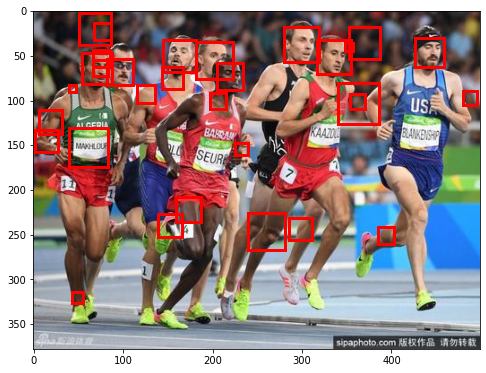

In [33]:
img = Image.open(img_path)
fig,ax = plt.subplots(figsize = (8,8))
ax.imshow(img)

for rec in rectangels:
    draw = patches.Rectangle(rec[0:2], rec[2]-rec[0], rec[3]-rec[1], facecolor = 'None', edgecolor = 'r', linewidth = 3)
    ax.add_patch(draw)

**onet的结果后处理**
Args:
* cls_prob: onet输出人脸类别的概率 (n,2)
* roi:onet输出人脸框的坐标,偏移值(n,4)
* pts:onet输出的face landmark(n,10)
* rectangles:rnet输出的结果
* width: 原图w
* height： 原图h
* threshold: 概率的阈值

处理流程：
* 根据阈值找到符合条件的点
* 找到rectangle里面的x1,y1,x2,y2,sc
* 找到roi输出的偏移量，并与rectangle结合
* 输出rectangle

In [34]:
def onet_process(cls_prob, roi, pts, rectangles, original_h, original_w, threshold):
    prob = cls_prob[:, 1]
    print(prob)
    pick = np.where(prob >= threshold)
    print(pick)
    rectangles = np.array(rectangles)
    
    x1 = rectangles[pick, 0]
    y1 = rectangles[pick, 1]
    x2 = rectangles[pick, 2]
    y2 = rectangles[pick, 3]

    sc = np.array([prob[pick]]).T
    
    dx1 = roi[pick, 0]
    dx2 = roi[pick, 1]
    dx3 = roi[pick, 2]
    dx4 = roi[pick, 3]
    
    w = x2-x1
    h = y2-y1
    
    pts0 = np.array([(x1+w*pts[pick, 0])[0]]).T
    pts1 = np.array([(y1+w*pts[pick, 5])[0]]).T
    pts2 = np.array([(x1+w*pts[pick, 1])[0]]).T
    pts3 = np.array([(y1+w*pts[pick, 6])[0]]).T
    pts4 = np.array([(x1+w*pts[pick, 2])[0]]).T
    pts5 = np.array([(y1+w*pts[pick, 7])[0]]).T
    pts6 = np.array([(x1+w*pts[pick, 3])[0]]).T
    pts7 = np.array([(y1+w*pts[pick, 8])[0]]).T
    pts8 = np.array([(x1+w*pts[pick, 4])[0]]).T
    pts9 = np.array([(y1+w*pts[pick, 9])[0]]).T
    
    x1 = np.array([(x1+w*dx1)[0]]).T
    y1 = np.array([(y1+h*dx2)[0]]).T
    x2 = np.array([(x2+w*dx3)[0]]).T
    y2 = np.array([(y2+h*dx4)[0]]).T
    
    rectangles = np.concatenate((x1,y1,x2,y2,sc,pts0,pts1,pts2,pts3,pts4,pts5,pts6,pts7,pts8,pts9), axis = 1)
    
    rectangles = rec2Squre(rectangles)
    print(len(rectangles))
    pick = []
    for i in range(len(rectangles)):
        x1 = int(max(0, rectangles[i][0]))
        y1 = int(max(0, rectangles[i][1]))
        x2 = int(min(original_w, rectangles[i][2]))
        y2 = int(min(original_h, rectangles[i][3]))
        sc = rectangles[i][4]
        
        if x2> x1 and y2>y1:
            pick.append([x1,y1,x2,y2,sc,rectangles[i][5],rectangles[i][6],rectangles[i][7],rectangles[i][8],rectangles[i][9],rectangles[i][10],rectangles[i][11],rectangles[i][12],rectangles[i][13],rectangles[i][14]])
    return NMS(pick, 0.3)

In [35]:
predict_onet_batch = []
for rectangle in rectangels:
    crop_img = copy_img[int(rectangle[1]):int(rectangle[3]), int(rectangle[0]):int(rectangle[2])]
    h,w,_ = crop_img.shape
    if h == 0 or w == 0:
        continue
    scaled_img = cv2.resize(crop_img, (48,48))
    predict_onet_batch.append(scaled_img)

In [36]:
predict_onet_batch = np.array(predict_onet_batch)

In [37]:
o_model = onet("onet.h5")
output = o_model.predict(predict_onet_batch)
output[0].shape

(31, 2)

In [38]:
cls_prob = output[0]
roi = output[1]
pts = output[2]

rectangles = onet_process(cls_prob, roi, pts, rectangels, 512, 512,0.7)

[9.7093856e-01 9.9788827e-01 9.9962926e-01 9.9996305e-01 9.5989537e-01
 9.9927598e-01 4.7713812e-04 9.9584562e-01 9.9383718e-01 3.7508816e-02
 8.0172401e-03 2.4965271e-02 1.2744968e-01 3.0188715e-02 6.7417316e-02
 5.9860530e-03 2.0727812e-01 3.8355247e-03 1.0740051e-02 6.4939614e-03
 1.1576749e-01 9.1225997e-02 7.7618249e-02 7.5901985e-02 1.7439332e-02
 4.0813617e-02 5.2391976e-01 9.5687844e-02 1.4824942e-03 3.6641648e-03
 5.8962129e-02]
(array([0, 1, 2, 3, 4, 5, 7, 8]),)
8


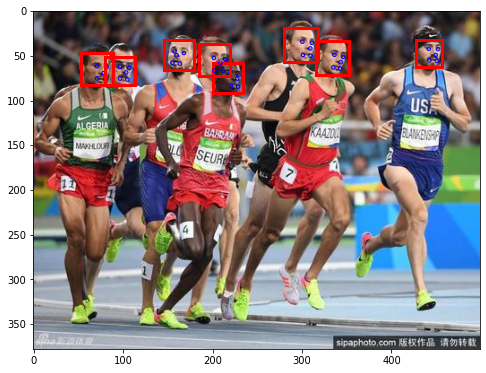

In [39]:
img = Image.open(img_path)
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img)
for rec in rectangles:
    draw = patches.Rectangle(rec[0:2], rec[2]-rec[0], rec[3]-rec[1], facecolor='None', edgecolor='r', linewidth=3)
    circle1 = patches.Circle(rec[5:7], 2, facecolor = 'None', edgecolor = 'b', linewidth = 1)
    circle2 = patches.Circle(rec[7:9], 2, facecolor = 'None', edgecolor = 'b', linewidth = 1)
    circle3 = patches.Circle(rec[9:11], 2, facecolor = 'None', edgecolor = 'b', linewidth = 1)
    circle4 = patches.Circle(rec[11:13], 2, facecolor = 'None', edgecolor = 'b', linewidth = 1)
    circle5 = patches.Circle(rec[13:15], 2, facecolor = 'None', edgecolor = 'b', linewidth = 1)
    ax.add_patch(draw)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)
    ax.add_patch(circle4)
    ax.add_patch(circle5)